This Notebook explores the possibility to isolate each bar in the image.

In later stages each bar can be evaluated for anomalies.

In [1]:
import os
import cv2
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import glob
import itertools as it


%load_ext ipydex.displaytools
%matplotlib inline

import time
time.ctime() ##:

plt.rcParams["figure.figsize"] = [12, 12]

In [2]:
img_path = "cropped/chunk001_shading_corrected/2023-06-26_08-47-39_C50.jpg"


def load_img(fpath):
    
    image1  = cv2.imread(fpath)
    
    # image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    
    # use BGR, do not convert
    
    return image1

def rgb(img):
    # useful for imshow
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
img0 = load_img(img_path)


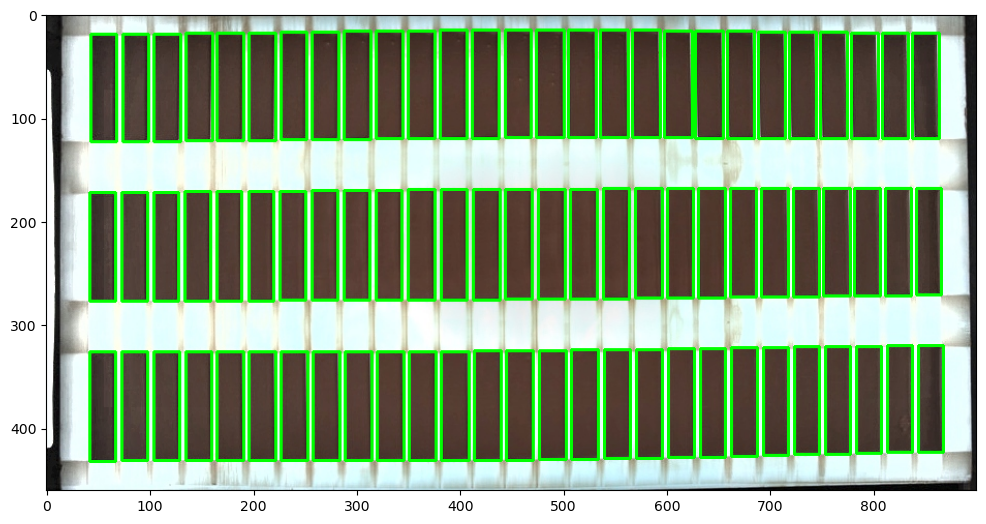

In [3]:
img2 = img0*1

gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

# Apply thresholding to binarize the image
_, thresh = cv2.threshold(gray, thresh=127, maxval=255, type=cv2.THRESH_BINARY)


inverted_thresh = 255 - thresh
#plt.imshow(inverted_thresh)

# Find the contours in the image
cnts, _ = cv2.findContours(inverted_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate over the contours and draw bounding rectangles around each one


BBOX_EXPECTED_WITH = 26
BBOX_EXPECTED_HEIGHT = 104
BBOX_TOL = 6

bboxes = []

for cnt in cnts:
    x, y, w, h = cv2.boundingRect(cnt)
    if (abs(w - BBOX_EXPECTED_WITH) > BBOX_TOL) or (abs(h - BBOX_EXPECTED_HEIGHT) > BBOX_TOL):
        continue
    else:
        # print(w, h, "--", abs(w - BBOX_EXPECTED_WITH) > BBOX_TOL, abs(h - BBOX_EXPECTED_HEIGHT) > BBOX_TOL)
        pass
        
    cv2.rectangle(img2,(x,y),(x + w,y + h),(0, 255, 0), 2)
    bboxes.append(np.r_[x, y, w, h])

bboxes = np.array(bboxes)    
    
plt.imshow(rgb(img2))

In [4]:
# this was generated from a reference image
if 0:

    xx, yy, ww, hh = bboxes.T
    xx.sort()
    yy.sort()

    dx_mean = np.average(np.diff(xx.reshape(-1, 3), axis=0)) ##:
    dy_mean = np.average(np.diff(yy.reshape(3, -1), axis=0)) ##:
else:
    # average distances between boxes
    dx_mean = 30.73076923076923
    dy_mean = 153.72222222222223

In [50]:
def get_bbbox_list(contour_list):
    res = []
    for cnt in cnts:
        
        x, y, w, h = cv2.boundingRect(cnt)
        if (abs(w - BBOX_EXPECTED_WITH) > BBOX_TOL) or (abs(h - BBOX_EXPECTED_HEIGHT) > BBOX_TOL):
            # in valid bounding box
            continue
        
        
        
        # these values will be assigned later
        row, col = -1, -1
        res.append([x, y, w, h, row, col])
    return res

def assign_row_col(bbox_list):
    """
    problem: The list of bounding boxes is not sorted. it has to be calculated in which row an col every bb is.
    """
    # 3 rows, 27 cols
    
    arr1 = np.array(bbox_list)
    xx, yy, ww, hh, _, _ = arr1.T
    
    xmin = np.min(xx)
    xmax = np.max(xx)
    
    ymin = np.min(yy)
    ymax = np.max(yy)
    
    xx_index_candidates = (xx - xmin)/dx_mean
    yy_index_candidates = (yy - ymin)/dy_mean
    
    xx_idcs = np.int16(xx_index_candidates.round())
    yy_idcs = np.int16(yy_index_candidates.round())
    
    # ensure that it is clear which index each bb refers to
    assert np.max(np.abs(xx_index_candidates - xx_idcs)) < 0.45
    assert np.max(np.abs(yy_index_candidates - yy_idcs)) < 0.45
    
    
    for i, (xx_idx, yy_idx) in enumerate(zip(xx_idcs, yy_idcs)):
        bbox_list[i][4] = yy_idx  # row
        bbox_list[i][5] = xx_idx  # col
        
    
    # sort such that first row comes first
    bbox_list.sort(key=lambda seq: seq[4]*1e4 + seq[5])


def index_combinations():
    return list(it.product(range(3), range(27)))


def find_missing_boxes(bbox_list):
    
    idcs = index_combinations()
    for bbox in bbox_list:
        row_col = tuple(bbox[-2:])
        
        try:
            idcs.remove(row_col)
        except ValueError:
            msg = f"unexpected row_col index pair: {row_col}"
            raise ValueError(msg)
    
    # in the nominal case this list is now empty
    return idcs

def handle_missing_boxes(bbox_list):
    missing_boxes = find_missing_boxes(bbox_list)
    
    if len(missing_boxes) > 0:
        raise NotImplementedError
    
    # TODO: 
    # next steps:
    # - detect missing bboxes
    # - isolate bars
    # - do statistics for each C0-bar (over many sample images)
    # - for every unclassified image: compare each bar to the C0 - statistics
    # -> identify candidates for non-C0 images
    pass

def convert_to_dict(bbox_list, img):
    
    idcs = index_combinations()
    res = {}
    for idx_pair, bbox in zip(idcs, bbox_list):
        assert list(idx_pair) == bbox[-2:], f"{list(idx_pair)=}  {bbox[-2:]=}"
        x, y, w, h = bbox[:4]
        res[idx_pair] = img[y:y+h, x:x + w, :]
        
    return res
        
def plot_bbox_hist(contour_list):
    
    bbox_list = get_bbbox_list(contour_list)
    
    fig, aax = plt.subplots(nrows=3, sharex=True, sharey=True,)
    
    
    #for i, (x, y, w, h) in enumerate(bbox_list):
    pass


In [53]:
bbox_list = get_bbbox_list(cnts) ##:i

assign_row_col(bbox_list)
handle_missing_boxes(bbox_list)

row_col_dict = convert_to_dict(bbox_list, img0)

info(bbox_list) := "<class 'list'> with length: 81"

---

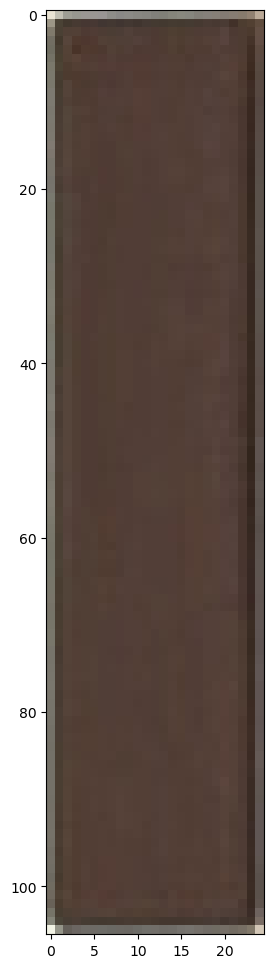

In [56]:

plt.imshow(rgb(row_col_dict[(1, 3)]))

In [45]:
bbox_list[:5]

[[43, 19, 25, 104, 0, 0],
 [74, 19, 25, 104, 0, 1],
 [104, 19, 26, 104, 0, 2],
 [135, 18, 26, 104, 0, 3],
 [165, 18, 26, 104, 0, 4]]

In [46]:
arr = np.array(bbox_list)

In [47]:
xx, yy, ww, hh, xx_idcs, yy_idcs = arr.T

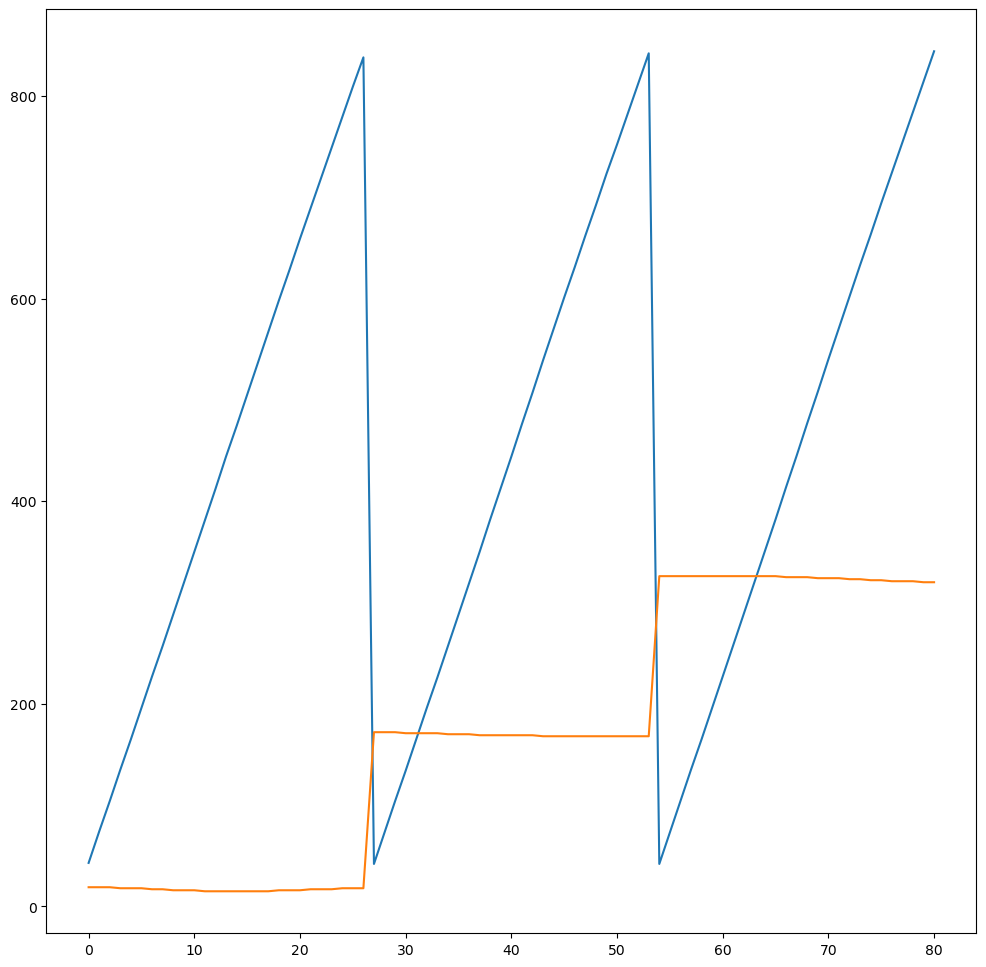

In [48]:
plt.plot(xx)
plt.plot(yy)

In [18]:
for bbox in bbox_list[:5]:
    pass
    # img2[*bbox]
    

In [19]:
bbox

[165, 18, 26, 104, 4, 0]

In [59]:
a- np.round(a)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

In [13]:
qq = get_bbbox_arr(cnts)

In [14]:
qq.shape

(105, 4)

In [25]:
bboxes.shape

(81, 4)

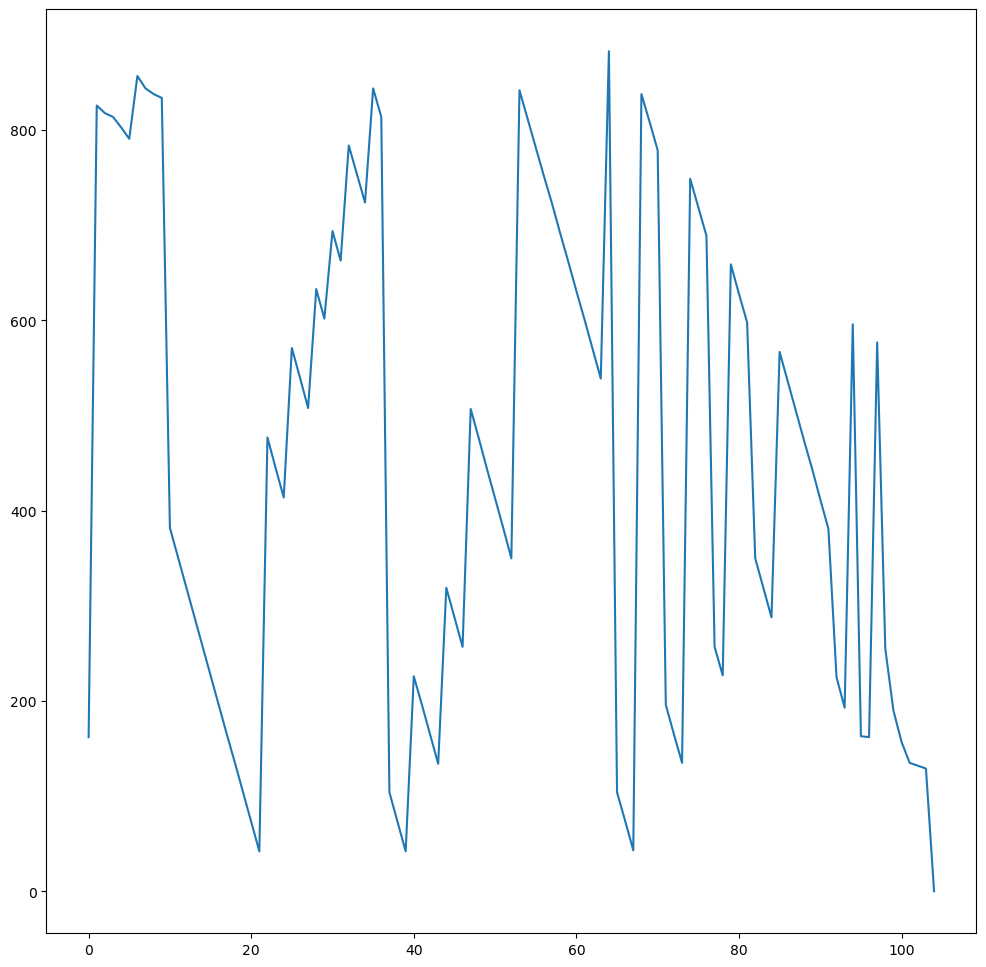

In [27]:
plt.plot(qq[:, 0])

(81,)

In [22]:
len(ww)

105

In [23]:
hh

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1, 105, 105, 105,
       105, 105, 105, 105, 105, 105, 105, 105, 106, 105, 106, 106, 105,
       105, 106, 105, 105, 104, 105, 103, 104, 104, 103, 103, 105, 105,
       105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107,
       107, 103, 104, 104, 104, 105, 105, 105, 106, 106, 106, 107,   1,
       104, 104, 104, 102, 102, 102, 104, 104, 104, 103, 103, 103, 104,
       104, 104, 104, 103, 104, 104, 105, 104, 104, 104, 104, 104, 105,
       105,   1,   1,   1,   9,   7, 460,   2,  12,   9,   2,   4,   1,
       460])